# Product Matching

Matching a query product image against a set of reference product images and finding the reference products that are most similar to the query product.

![](../MISC/matching_header.PNG)

In [36]:
import sys
sys.path.append("../python_code")
from AttrPredModel import AttrPred_Resnet50
from iMatDataset import iMatDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from PIL import Image
device = torch.device("cuda:3")

### loading reference dataset

In [17]:
# paths to dataset folder must be changed according to your file structure
ds = iMatDataset(labels_file="/home/mprinzler/storage/iMaterialist/validation.json", img_dir="/home/mprinzler/storage/iMaterialist/val", attr_descr_file="/home/mprinzler/storage/iMaterialist/iMat_fashion_2018_label_map_228.csv",
                rgb_mean=[0.6742, 0.6307, 0.6173], rgb_std=[0.6742, 0.6307, 0.6173])

### loading model

In [25]:
# path to downloaded model file. Must be adapted to fit your file structure!
model_path = "../TrainedModels/epoch=3.ckpt"
model = AttrPred_Resnet50.load_from_checkpoint(model_path)
model.eval()
model.to(device)
print("Model Loaded successfully")

Model Loaded successfully


### analyzing reference product images

In [31]:
# calculate attribute scores for reference images  -> NOT NECESSARY IF "ref_attr_scores.pth" exists
dataloader = DataLoader(ds, batch_size=100)
ref_attr_scores = []
with torch.no_grad():
    for batch in tqdm(iterable=dataloader):
        img_tensors, _ = batch
        img_tensors = img_tensors.to(device)
        ref_attr_scores.append(model(img_tensors).cpu())
        del img_tensors
ref_attr_scores = torch.cat(ref_attr_scores, dim=0)

# saving reference attribute scores so that don't have to be recalculated everytime
torch.save(ref_attr_scores, "ref_attr_scores.pth")

100%|██████████| 99/99 [11:54<00:00,  7.21s/it]


In [34]:
# loading previously saved ref_attr_scores (if existing)
ref_attr_scores = torch.load("ref_attr_scores.pth")

### retreive attribute scores for query images

Query product


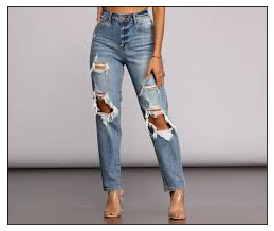

In [79]:
# load query image
query_img_path = "../MISC/jeans.jpg"
query_img_pil = Image.open(query_img_path).convert("RGB")
print("Query product")
plt.imshow(query_img_pil)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [80]:
# retreive similar products
pred_attr_scores = model(ds.trafo_pil2tensor(query_img_pil).unsqueeze(0).to(device))[0].cpu()

### find reference products with most similar attribute scores

Similar reference Products:


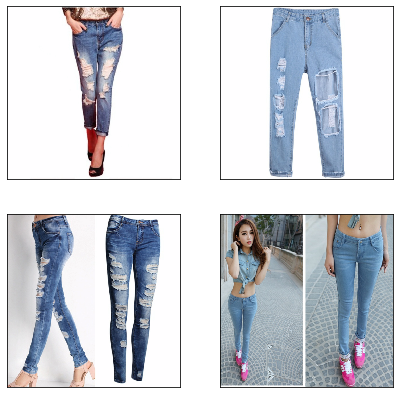

<Figure size 432x288 with 0 Axes>

In [81]:
ref_attr_score_distances = torch.sum((pred_attr_scores - ref_attr_scores)**2, dim=1).sqrt()
closest_4 = torch.argsort(ref_attr_score_distances)[:4].tolist()

print("Similar reference Products:")
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,7))
for i, ref_idx in enumerate(closest_4):
    img_tensor, _ = ds[ref_idx]
    img_pil = ds.trafo_tensor2pil(img_tensor)
    axes.flatten()[i].imshow(img_pil)
    axes.flatten()[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig("../MISC/matches.png")
plt.show()
plt.tight_layout()